In [1]:
# Connect do drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import time
import gc
import math

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip install hdf5storage
import hdf5storage
from scipy.signal import butter, filtfilt, savgol_filter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.fft import fft, fftfreq, fft2, rfft
from scipy.signal import iirnotch, freqz
from scipy.signal import spectrogram

import keras
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Preserving loading of original cnn model for reference to report
cnn_model_file = "/content/drive/MyDrive/grid_search_84.h5"
cnn_model = keras.models.load_model(cnn_model_file)

In [ ]:
# Top channels across all classes

global_channel_importance = np.sum(np.abs(shap_values), axis=(0, 1, 2, 4))  # Shape: (256,)
top_n = 10
top_channels = np.argsort(-global_channel_importance)[:top_n]  # Indices of top channels
top_importance_values = global_channel_importance[top_channels]  # Corresponding SHAP magnitudes

print("Top channels (indices):", top_channels)
print("Their importance scores:", top_importance_values)

Top channels (indices): [77 76 79  9 69 81 71 80 13 66]
Their importance scores: [12.3036876   9.64695512  5.78294862  4.06781742  2.80832135  2.53352388
  2.31020385  2.09851658  1.88181463  1.68405792]


In [3]:
# Luca code
def import_mat(fn):
    data = hdf5storage.loadmat(fn)
    raw = data["data"]["raw"][0][0]
    epoched = data["data"]["epoched"][0][0]
    event_times = data["data"]["event_times"][0][0]
    event_names = data["data"]["event_names"][0][0]
    param_dict = {}
    param_dict["hand"] = data["data"]["hand"][0][0][0]
    param_dict["spikes"] = data["data"]["spikes"][0][0][0][0][0]
    param_dict["aligned_to"] = data["data"]["alignedTo"][0][0][0][0][0]
    param_dict["angle"] = data["data"]["angle"][0][0][0]
    param_dict["event_times"] = event_times
    param_dict["event_names"] = event_names
    return raw, epoched, param_dict

def butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Compute the filter coefficients for a Butterworth bandpass filter.
    """
    # Compute the Nyquist frequency
    nyq = 0.5 * fs
    # Compute the low and high frequencies
    low = lowcut / nyq
    high = highcut / nyq
    # Compute the filter coefficients
    b, a = butter(order, [low, high], btype="band")
    # Return the filter coefficients
    return b, a


def bandpass_filter(lfp, fs, lowcut, highcut):
    """
    Apply a bandpass filter to the LFP signal.
    """
    # Compute the filter coefficients
    b, a = butter_bandpass(lowcut, highcut, fs)
    # Apply the filter
    lfp_filtered = filtfilt(b, a, lfp, axis=0)
    # Return the filtered LFP signal
    return lfp_filtered

def compute_eeg_spectrograms(data, fs=2000, nperseg=200, noverlap=100):
    """
    Compute spectrograms for each neuron in EEG data.

    Parameters:
    - data: ndarray of shape (256, 508, num_trials, 5)
    - fs: Sampling frequency
    - nperseg: Length of each FFT segment
    - noverlap: Overlap between segments

    Returns:
    - spectrograms: ndarray of shape (num_total_trials, 256, n_freq_bins, n_time_windows)
    """
    n_neurons, n_time, n_trials, n_classes = data.shape
    all_specs = []

    for cls in range(n_classes):
        for trial in range(n_trials):
            trial_specs = []
            for neuron in range(n_neurons):
                signal = data[neuron, :, trial, cls]
                f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
                trial_specs.append(Sxx)  # Sxx shape: (n_freq_bins, n_time_windows)
            trial_specs = np.stack(trial_specs, axis=0)  # Shape: (256, n_freq_bins, n_time_windows)
            all_specs.append(trial_specs)

    all_specs = np.stack(all_specs, axis=0)  # Shape: (n_total_trials, 256, n_freq_bins, n_time_windows)
    return f, all_specs.transpose(0, 2, 3, 1)

def visualize_spectogram(Sxx, f, t, title = "Example Spectrogram", normalize=True):
    # Normalize each frequency bin by its mean (or max) across time
    if normalize:
        Sxx_max = np.max(Sxx, axis=1, keepdims=True)
        Sxx_min = np.min(Sxx, axis=1, keepdims=True)
        Sxx = (Sxx - Sxx_min) / (Sxx_max - Sxx_min)
    plt.imshow(Sxx, aspect='auto', origin='lower',
              extent=[t[0], t[-1], f[0], f[-1]], cmap='viridis')

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.title(title)

    num_yticks = len(f)
    yticks = np.linspace(f[0], f[-1], int(num_yticks/5))
    plt.yticks(yticks, labels=np.round(yticks))

    num_xticks = len(t)
    xticks = np.linspace(t[0], t[-1], num_xticks)
    plt.xticks(xticks, labels=np.round(xticks, 3), rotation=45)
    plt.savefig(f"{title}.pdf", format='pdf')
    plt.show()

def clean_spectograms(spectograms, f, remove_freqs, fs, window_size, upper_bound):
    cleaned_spectograms = []
    lower_bound = int(math.ceil(fs / window_size / 10.0) * 10)
    lower_bound_indx = np.where(f >= lower_bound)[0][0]
    upper_bound_indx = np.where(f <= upper_bound)[0][-1]
    mask = (f >= remove_freqs-2) & (f <= remove_freqs+2)
    harmonics = np.arange(remove_freqs, f[-1], remove_freqs)

    for trial in spectograms:
        cleaned_spectogram_per_trial = []
        for channel in trial:
            cleaned_spectogram = channel
            for h in harmonics:
                mask = (f >= h-2) & (f <= h+2)
                cleaned_spectogram[mask, :] = 0
            cleaned_spectogram = cleaned_spectogram[lower_bound_indx:upper_bound_indx]
            cleaned_spectogram_per_trial.append(cleaned_spectogram)
        cleaned_spectograms.append(cleaned_spectogram_per_trial)
    f = f[lower_bound_indx:upper_bound_indx]
    return np.array(cleaned_spectograms), f

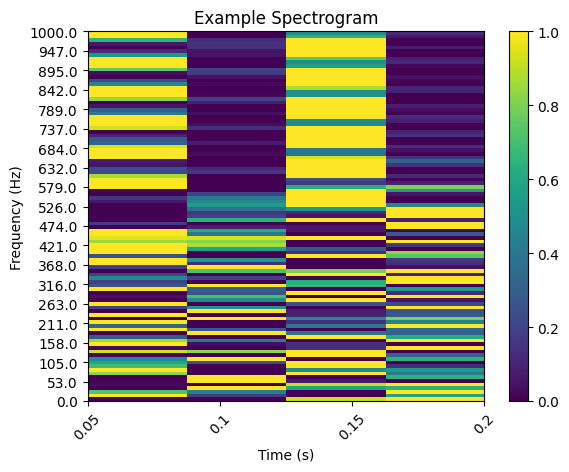

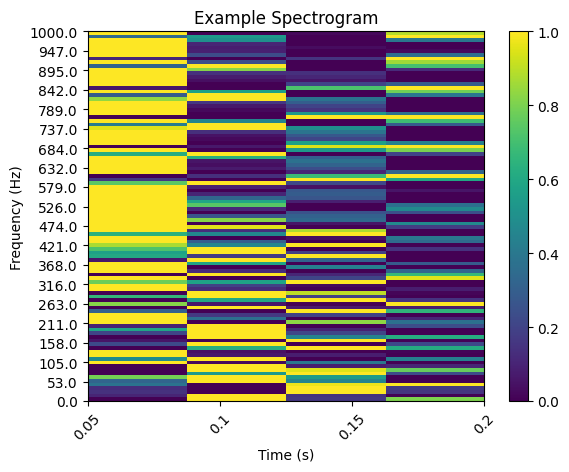

12044

In [5]:
# Data load pipeline

# Load data
_, epoched1, _ = import_mat('/content/drive/MyDrive/data/1_data_left_0.mat')
_, epoched2, _ = import_mat('/content/drive/MyDrive/data/2_data_left_45.mat')
_, epoched3, _ = import_mat('/content/drive/MyDrive/data/3_data_left_90.mat')
_, epoched4, _ = import_mat('/content/drive/MyDrive/data/4_data_left_135.mat')
_, epoched5, _ = import_mat('/content/drive/MyDrive/data/5_data_right_0.mat')
_, epoched6, _ = import_mat('/content/drive/MyDrive/data/6_data_right_45.mat')
_, epoched7, _ = import_mat('/content/drive/MyDrive/data/7_data_right_90.mat')
_, epoched8, _ = import_mat('/content/drive/MyDrive/data/8_data_right_135.mat')

epoched_left = np.concatenate((epoched1, epoched2, epoched3, epoched4), axis=2)
epoched_right = np.concatenate((epoched5, epoched6, epoched7, epoched8), axis=2)
left_trials = epoched1.shape[2] + epoched2.shape[2] + epoched3.shape[2] + epoched4.shape[2]
right_trials = epoched5.shape[2] + epoched6.shape[2] + epoched7.shape[2] + epoched8.shape[2]

# Delete individual datasets to free memory
del epoched1, epoched2, epoched3, epoched4, epoched5, epoched6, epoched7, epoched8
del _

# Force garbage collection
gc.collect()

# Create spectrograms
fl, specs_left = compute_eeg_spectrograms(epoched_left)
_, specs_right = compute_eeg_spectrograms(epoched_right)

# Create labels
y_left = np.repeat(np.arange(0, 5), epoched_left.shape[2])
zeros = np.zeros(epoched_right.shape[2])
y_part_right = np.repeat(np.arange(5, 9), epoched_right.shape[2])
y_right = np.concatenate([zeros, y_part_right])
y_total = np.concatenate((y_left, y_right), axis=0)

# Clean spectrograms
X_total = np.concatenate((specs_left, specs_right), axis=0)
X_total = X_total.transpose(0, 3, 1, 2)
X_final, f = clean_spectograms(X_total, fl, remove_freqs=60, fs=2000, window_size=200, upper_bound=500)
X_final = X_final.transpose(0, 2, 3, 1)

# Remove top channels (list pulled by Luca's code)
channels_to_remove = [0, 1, 3, 5, 9, 30, 52, 63, 81, 88, 92]
channels_to_keep = [i for i in range(X_final.shape[-1]) if i not in channels_to_remove]
X_final = X_final[:, :, :, channels_to_keep]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_total, test_size=0.2, random_state=42)

del epoched_left, epoched_right, specs_left, specs_right, X_total, X_final, y_total, y_left, y_right
gc.collect()

In [7]:
# Load new models

new_cnn = keras.models.load_model('/content/drive/MyDrive/new_cnn_cleaned_752.keras')

cnn_lstm_832 = keras.models.load_model('/content/drive/MyDrive/new_cnn_lstm_cleaned_832.keras')
cnn_lstm_816 = keras.models.load_model('/content/drive/MyDrive/new_cnn_lstm_cleaned_816.keras')

parallel_816 = keras.models.load_model('/content/drive/MyDrive/new_parallel_cleaned_816.keras')
parallel_822 = keras.models.load_model('/content/drive/MyDrive/new_parallel_cleaned_822.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [79]:
# Parameter numbers

print("CNN parameters:", new_cnn.count_params())
print("CNN-LSTM 83.2% parameters:", cnn_lstm_832.count_params())
print("CNN-LSTM 81.6% parameters:", cnn_lstm_816.count_params())
print("Parallel 81.6% parameters:", parallel_816.count_params())
print("Parallel 82.2% parameters:", parallel_822.count_params())


CNN parameters: 484137
CNN-LSTM 83.2% parameters: 256201
CNN-LSTM 81.6% parameters: 465865
Parallel 81.6% parameters: 719049
Parallel 82.2% parameters: 708361


In [8]:
# Training accuracies

print("CNN accuracy:", new_cnn.evaluate(X_train, y_train)[1])
print("CNN-LSTM 83.2% accuracy:", cnn_lstm_832.evaluate(X_train, y_train)[1])
print("CNN-LSTM 81.6% accuracy:", cnn_lstm_816.evaluate(X_train, y_train)[1])
print("Parallel 81.6% accuracy:", parallel_816.evaluate(X_train, y_train)[1])
print("Parallel 82.2% accuracy:", parallel_822.evaluate(X_train, y_train)[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9034 - loss: 0.2958
CNN accuracy: 0.8801587224006653
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9278 - loss: 0.2434
CNN-LSTM 83.2% accuracy: 0.8992063403129578
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9220 - loss: 0.2453
CNN-LSTM 81.6% accuracy: 0.8999999761581421
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9592 - loss: 0.1697
Parallel 81.6% accuracy: 0.9277777671813965
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9613 - loss: 0.1588
Parallel 82.2% accuracy: 0.9293650984764099


In [40]:
# Create explainers for cnn
background = shap.utils.sample(X_train, 100)  # 100 reference samples
cnn_explainer = shap.DeepExplainer(new_cnn, background)

# Explain predictions
shap_values_cnn = cnn_explainer.shap_values(X_test[0:10])  # Can adjust number of samples

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_65
Received: inputs=['Tensor(shape=(100, 49, 4, 245))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_65
Received: inputs=['Tensor(shape=(200, 49, 4, 245))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_65
Received: inputs=['Tensor(shape=(10, 49, 

In [41]:
# Top channels across all classes

global_channel_importance = np.mean(np.abs(shap_values_cnn), axis=(0, 1, 2, 4))
top_n = 10
top_channels = np.argsort(-global_channel_importance)[:top_n]  # Indices of top channels

original_channel_index = []
for i in top_channels:
    original_channel_index.append(channels_to_keep[i])

top_importance_values = global_channel_importance[top_channels]  # Corresponding SHAP magnitudes

print("Top channels (indices):", top_channels)
print("Top channels (original):", original_channel_index)
print("Their importance scores:", top_importance_values)

Top channels (indices): [ 68  69  71  63   4  72   8  64  62 240]
Top channels (original): [76, 77, 79, 71, 8, 80, 13, 72, 70, 251]
Their importance scores: [0.0042409  0.00415514 0.00300489 0.00179102 0.00154153 0.00107843
 0.00101691 0.00095305 0.00080231 0.00080117]


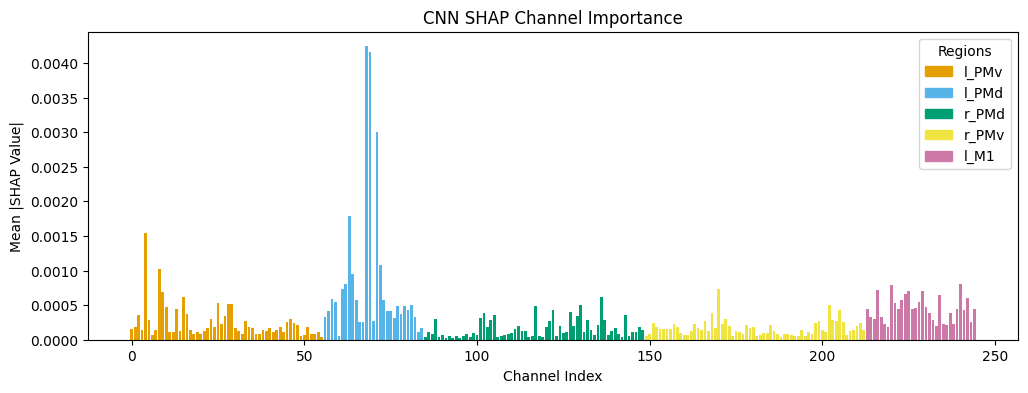

In [46]:
# bar plot of top channels
channel_indices = np.arange(len(global_channel_importance))
colors = [region_colors[get_region_for_channel(i)] for i in channel_indices]

plt.figure(figsize=(12, 4))
plt.bar(channel_indices, global_channel_importance, color=colors)
plt.xlabel("Channel Index")
plt.ylabel("Mean |SHAP Value|")
plt.title("CNN SHAP Channel Importance")
handles = [plt.Rectangle((0,0),1,1, color=region_colors[label]) for label in regions.keys()]
plt.legend(handles, regions.keys(), title="Regions")
plt.savefig("cnn_shap_channels.pdf", format='pdf')
plt.show()

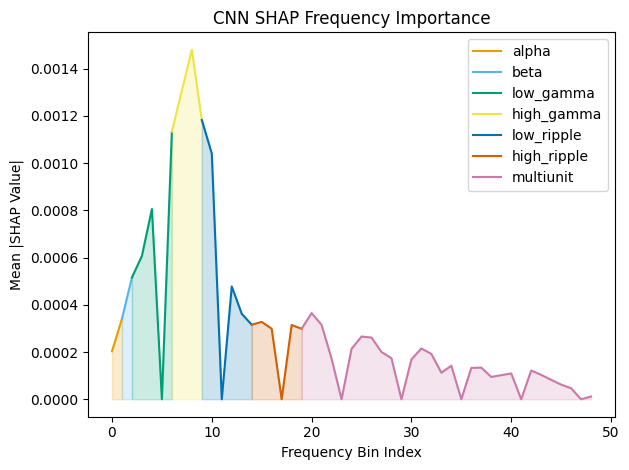

In [43]:
# And using SHAP to try and get feature importance
bands = {
    'alpha': (0, 1),
    'beta':  (1, 2),
    'low_gamma': (2, 6),
    'high_gamma': (6, 9),
    'low_ripple': (9, 14),
    'high_ripple': (14, 19),
    'multiunit': (19, 49)
}

freq_importance = np.mean(np.abs(shap_values_cnn), axis=(0, 2, 3, 4))

color_ranges = {
    (0, 1): '#E69F00',  # orange
    (1, 2): '#56B4E9',  # sky blue
    (2, 6): '#009E73',  # green
    (6, 9): '#F0E442',  # yellow
    (9, 14): '#0072B2', # blue
    (14, 19): '#D55E00', # vermilion
    (19, 49): '#CC79A7' # redish purple
}

for band_name, (f_start, f_end) in bands.items():
    plot_freq_importance = freq_importance[f_start:f_end + 1]
    x_values = range(f_start, f_start + len(plot_freq_importance))
    color = color_ranges[(f_start, f_end)]
    plt.plot(x_values, plot_freq_importance, color=color, label=band_name)
    plt.fill_between(x_values, plot_freq_importance, color=color, alpha=0.2)
plt.legend()
plt.xlabel("Frequency Bin Index")
plt.ylabel("Mean |SHAP Value|")
plt.title("CNN SHAP Frequency Importance")
plt.tight_layout()

plt.savefig("cnn_shap_freqs.pdf", format='pdf')

plt.show()


In [35]:
# Testing ablation on the models
regions = {
    'l_PMv': (0, 55),
    'l_PMd': (56, 84),
    'r_PMd': (85, 148),
    'r_PMv': (149, 212),
    'l_M1': (213, 244)
}

region_colors = {
    'l_PMv': '#E69F00',  # orange
    'l_PMd': '#56B4E9',  # sky blue
    'r_PMd': '#009E73',  # green
    'r_PMv': '#F0E442',  # yellow
    'l_M1':  '#CC79A7',  # redish purple
}

def get_region_for_channel(channel_idx):
    for region, (start, end) in regions.items():
        if start <= channel_idx <= end:
            return region

def ablation_testing(model, X_test, y_test):
  baseline_acc = model.evaluate(X_test, y_test, verbose=0)[1]
  acc_drops = {}

  for i in range(X_test.shape[3]):
    X_test_ablated = X_test.copy()
    X_test_ablated[..., i] = 0
    accuracy_drop = baseline_acc - model.evaluate(X_test_ablated, y_test, verbose=0)[1]
    acc_drops[i] = accuracy_drop

  sorted_items_asc = sorted(acc_drops.items(), key=lambda item: item[1], reverse=True)
  print("Sorted by value (ascending):", sorted_items_asc)

  return sorted_items_asc

def plot_ablation_drops(sorted_acc_drops, model_name):
  y_vals = [item[1] for item in sorted_acc_drops]
  x_vals = [item[0] for item in sorted_acc_drops]
  colors = [region_colors[get_region_for_channel(item[0])] for item in sorted_acc_drops]
  labels = list(regions.keys())

  original_channel_index = []
  for item in sorted_acc_drops:
    original_channel_index.append(channels_to_keep[item[0]])

  plt.figure(figsize=(12, 4))
  plt.bar(x_vals, y_vals, color=colors)
  plt.xlabel("Channel Index")
  plt.ylabel("Accuracy Drop")
  plt.title(f"{model_name} Channel Ablation Accuracy Drops")
  handles = [plt.Rectangle((0,0),1,1, color=region_colors[label]) for label in regions.keys()]
  plt.legend(handles, regions.keys(), title="Regions")
  plt.savefig(f"{model_name}_channel_ablation_drops.pdf", format='pdf')
  plt.show()

def region_ablation(model, X_test, y_test, model_name):
  channels_to_remove = [0, 1, 3, 5, 9, 30, 52, 63, 81, 88, 92]

  acc_drops = {}
  baseline_acc = model.evaluate(X_test, y_test, verbose=0)[1]

  for region, (e_start, e_end) in regions.items():
    X_masked = X_test.copy()
    X_masked[:, :, :, e_start : e_end + 1] = 0.0

    masked_acc = model.evaluate(X_masked, y_test, verbose=0)[1]
    acc_drops[region] = baseline_acc - masked_acc

  # plot differences
  sorted_items_asc = sorted(acc_drops.items(), key=lambda item: item[1], reverse=True)
  y_vals = [item[1] for item in sorted_items_asc]
  x_vals = [item[0] for item in sorted_items_asc]
  colors = [region_colors[region] for region in x_vals]

  plt.figure(figsize=(12, 4))
  plt.bar(x_vals, y_vals, color=colors)
  plt.axhline(0, color='black', linestyle='-')
  plt.xlabel("Region")
  plt.ylabel("Accuracy Drop")
  plt.xticks(x_vals)
  plt.title(f"{model_name} Regional Ablation Accuracy Drops")
  plt.savefig(f"{model_name}_region_ablation_drops.pdf", format='pdf')
  plt.show()


  return acc_drops

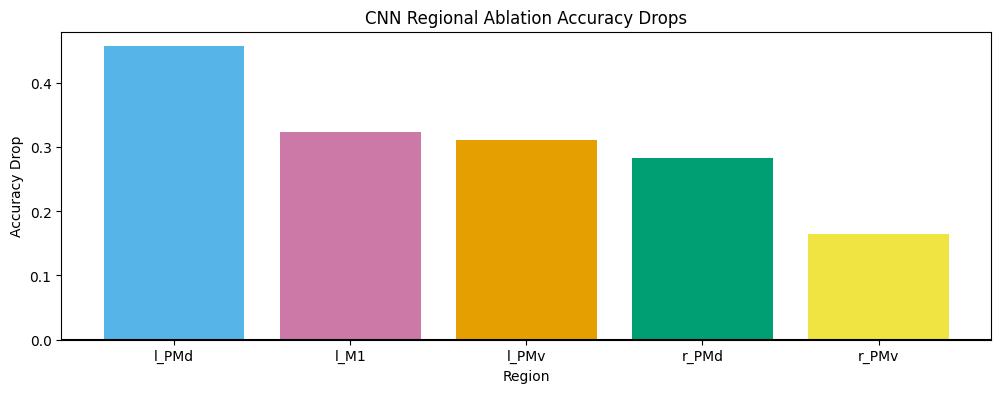

{'l_PMv': 0.31111112236976624,
 'l_PMd': 0.4571428596973419,
 'r_PMd': 0.2825396955013275,
 'r_PMv': 0.16507935523986816,
 'l_M1': 0.32380953431129456}

In [47]:
region_ablation(new_cnn, X_test, y_test, "CNN")

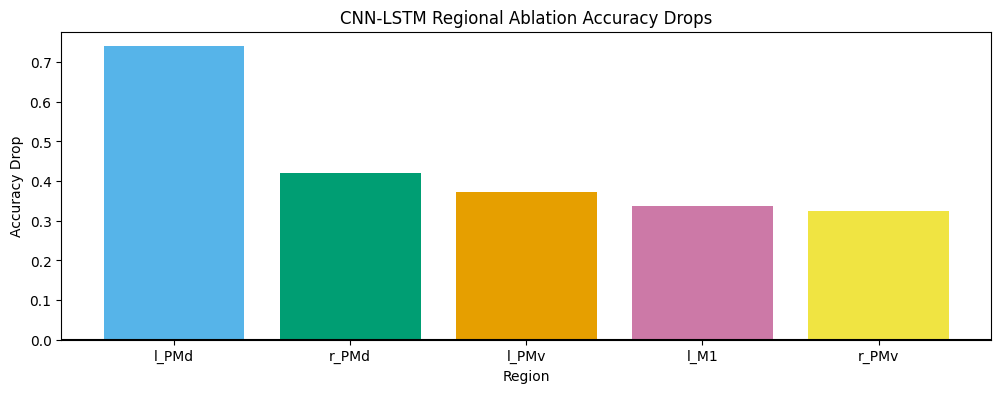

{'l_PMv': 0.37142857909202576,
 'l_PMd': 0.7396825477480888,
 'r_PMd': 0.41904762387275696,
 'r_PMv': 0.32380950450897217,
 'l_M1': 0.3365079462528229}

In [48]:
region_ablation(cnn_lstm_832, X_test, y_test, "CNN-LSTM")

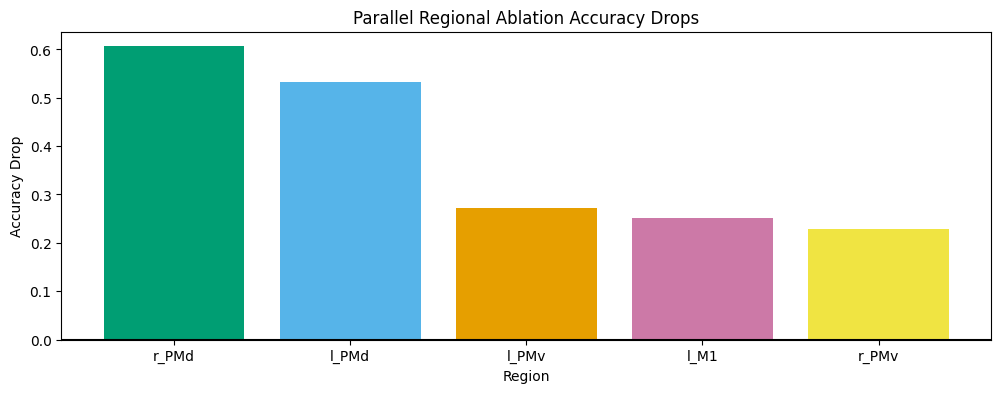

{'l_PMv': 0.2730158567428589,
 'l_PMd': 0.5333333313465118,
 'r_PMd': 0.6063492149114609,
 'r_PMv': 0.22857141494750977,
 'l_M1': 0.2507936358451843}

In [49]:
region_ablation(parallel_822, X_test, y_test, "Parallel")

In [20]:
# IMPORTANT: I believe for these numbers you need to add the number of channels removed
# [0, 1, 3, 5, 9, 30, 52, 63, 81, 88, 92]

print('Ablation for CNN w/ 75.2% test accuray: ')
cnn_acc_drops = ablation_testing(new_cnn, X_test, y_test)

print('Ablation for CNN-LSTM w/ 83.2% test accuray: ')
cnn_lstm_acc_drops = ablation_testing(cnn_lstm_832, X_test, y_test)

print('Ablation for Parallel w/ 82.2% test accuray: ')
parallel_acc_drops = ablation_testing(parallel_822, X_test, y_test)

Ablation for CNN w/ 75.2% test accuray: 
Sorted by value (ascending): [(68, 0.3492063581943512), (71, 0.3047619163990021), (63, 0.08253967761993408), (69, 0.08253967761993408), (72, 0.06984126567840576), (61, 0.02539682388305664), (15, 0.02222222089767456), (65, 0.02222222089767456), (28, 0.01904761791229248), (2, 0.0158730149269104), (62, 0.0158730149269104), (78, 0.0158730149269104), (170, 0.0158730149269104), (45, 0.01269841194152832), (73, 0.01269841194152832), (77, 0.01269841194152832), (79, 0.01269841194152832), (81, 0.01269841194152832), (124, 0.01269841194152832), (221, 0.01269841194152832), (117, 0.00952380895614624), (175, 0.00952380895614624), (220, 0.00952380895614624), (238, 0.00952380895614624), (240, 0.00952380895614624), (5, 0.00634920597076416), (16, 0.00634920597076416), (22, 0.00634920597076416), (25, 0.00634920597076416), (31, 0.00634920597076416), (56, 0.00634920597076416), (59, 0.00634920597076416), (70, 0.00634920597076416), (74, 0.00634920597076416), (82, 0.0063

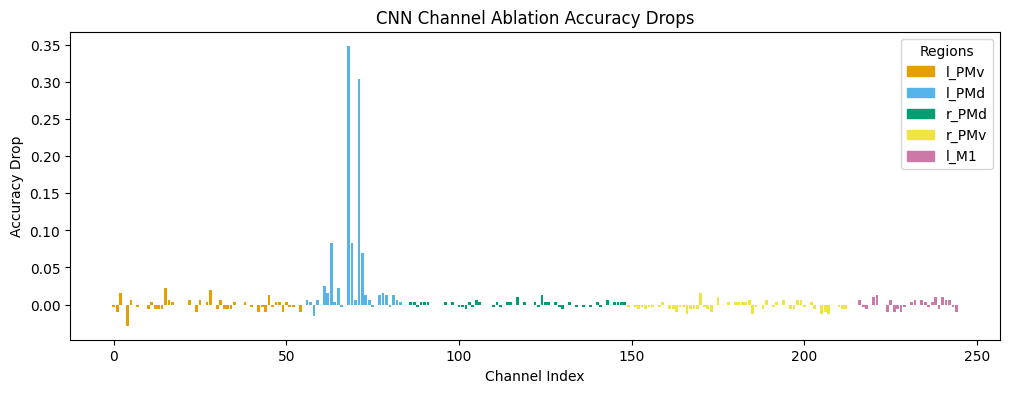

In [36]:
plot_ablation_drops(cnn_acc_drops, "CNN")

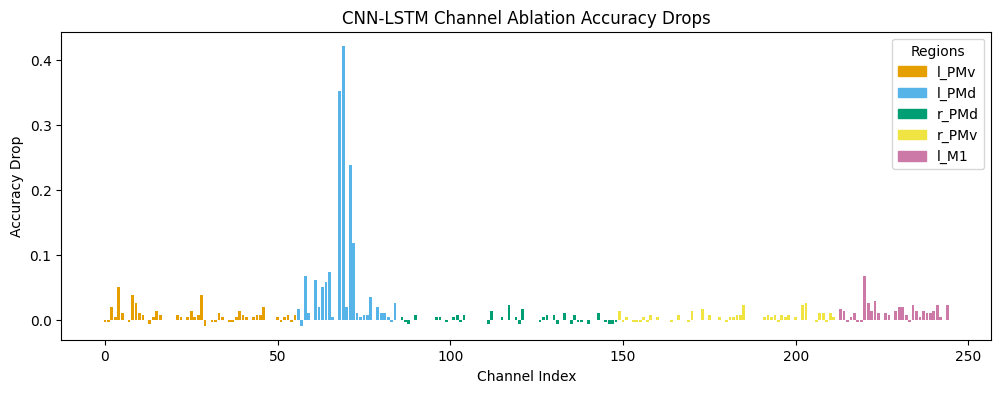

In [37]:
plot_ablation_drops(cnn_lstm_acc_drops, "CNN-LSTM")

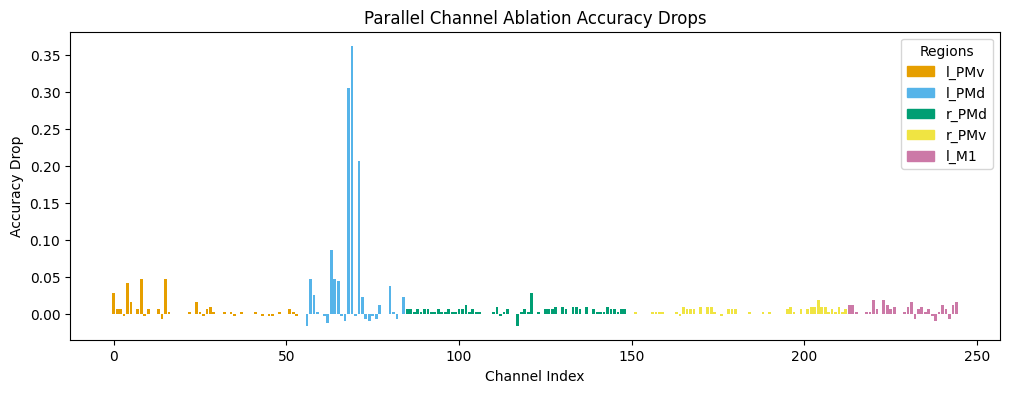

In [38]:
plot_ablation_drops(parallel_acc_drops, "Parallel")

In [53]:
# Attempt to test frequencies
def occlusion_importance_per_band(model, X_val, y_val, bands, model_name="", show_heatmap=True):
    """
    For each band, zero out those freq bins in X_val and measure drop in accuracy.
    Returns a dict: {band_name: ΔAccuracy}.
    """
    # Baseline accuracy on X_val
    baseline_acc = model.evaluate(X_val, y_val, verbose=0)[1]

    band_importances = {}
    for band_name, (f_start, f_end) in bands.items():
        X_masked = X_val.copy()
        # Zero out those bins in *all channels* and *all time*:
        X_masked[:, f_start : f_end + 1, :, :] = 0.0

        masked_acc = model.evaluate(X_masked, y_val, verbose=0)[1]
        band_importances[band_name] = baseline_acc - masked_acc

    for i in range(len(bands)):
      for j in range(i+1, len(bands)):
        band_name_1 = list(bands.keys())[i]
        band_name_2 = list(bands.keys())[j]
        f_start_1, f_end_1 = bands[band_name_1]
        f_start_2, f_end_2 = bands[band_name_2]

        X_masked = X_val.copy()
        X_masked[:, f_start_1 : f_end_1 + 1, :, :] = 0.0
        X_masked[:, f_start_2 : f_end_2 + 1, :, :] = 0.0

        masked_acc = model.evaluate(X_masked, y_val, verbose=0)[1]
        band_importances[f"{band_name_1} + {band_name_2}"] = baseline_acc - masked_acc

    if show_heatmap:
      plt.figure(figsize=(12, 6))

      # Prepare data - separate single bands and combinations
      single_bands = [b for b in band_importances if '+' not in b]
      combos = [b for b in band_importances if '+' in b]

      # Create matrix for heatmap
      n_bands = len(single_bands)
      heatmap_matrix = np.zeros((n_bands, n_bands))

      # Fill diagonal with single band importance
      np.fill_diagonal(heatmap_matrix, [band_importances[b] for b in single_bands])

      # Fill off-diagonal with combination importance
      for combo in combos:
          parts = combo.split(' + ')
          i = single_bands.index(parts[0])
          j = single_bands.index(parts[1])
          heatmap_matrix[i,j] = band_importances[combo]
          heatmap_matrix[j,i] = band_importances[combo]  # symmetric

      # Create heatmap
      plt.imshow(heatmap_matrix, cmap='YlOrRd')
      plt.colorbar(label='Accuracy Drop')
      plt.title(f"Band Importance Heatmap\n{model_name} (Baseline: {baseline_acc:.1%})")
      plt.xticks(np.arange(n_bands), single_bands, rotation=45)
      plt.yticks(np.arange(n_bands), single_bands)

      # Annotate values
      for i in range(n_bands):
          for j in range(n_bands):
              if i == j:
                  plt.text(j, i, f"{heatmap_matrix[i,j]:.3f}",
                          ha='center', va='center', color='black')
              else:
                  plt.text(j, i, f"{heatmap_matrix[i,j]:.3f}",
                          ha='center', va='center', color='black')

      plt.tight_layout()

      plt.savefig(f"{model_name}_freq_ablation_heatmap.pdf", format='pdf')

      plt.show()

    return band_importances

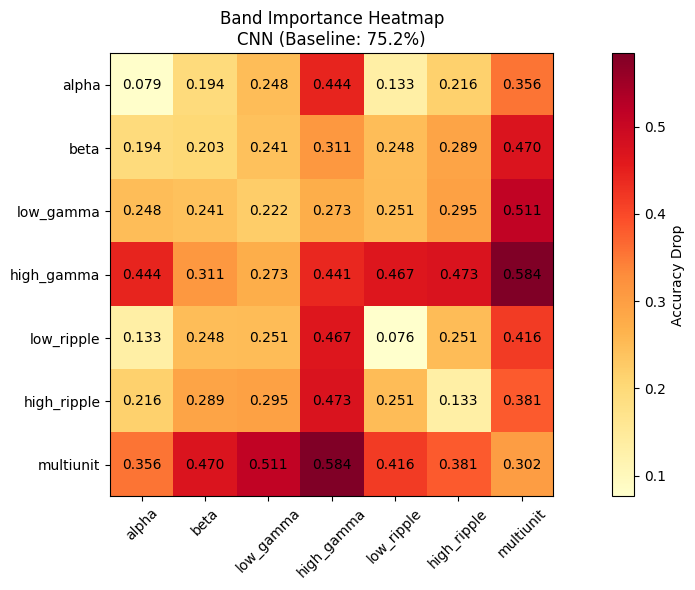

In [54]:
band_imp_cnn = occlusion_importance_per_band(new_cnn, X_test, y_test, bands, model_name="CNN")


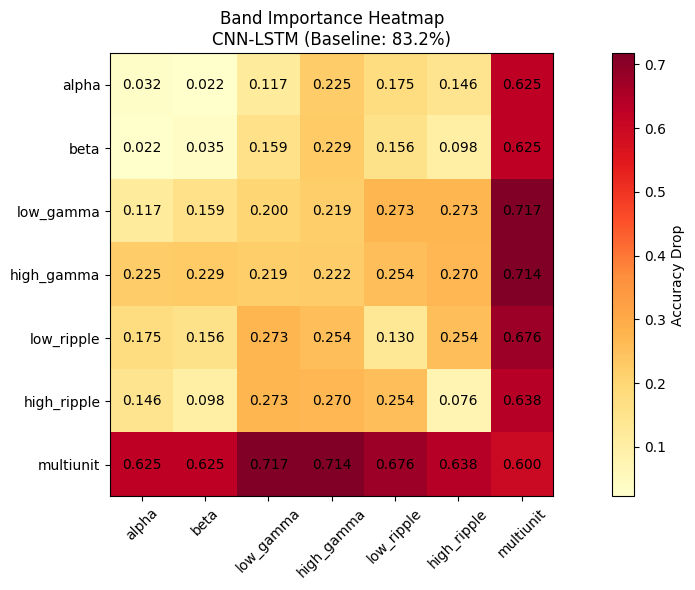

In [56]:
band_imp_cnn_lstm_819 = occlusion_importance_per_band(cnn_lstm_832, X_test, y_test, bands, model_name="CNN-LSTM")


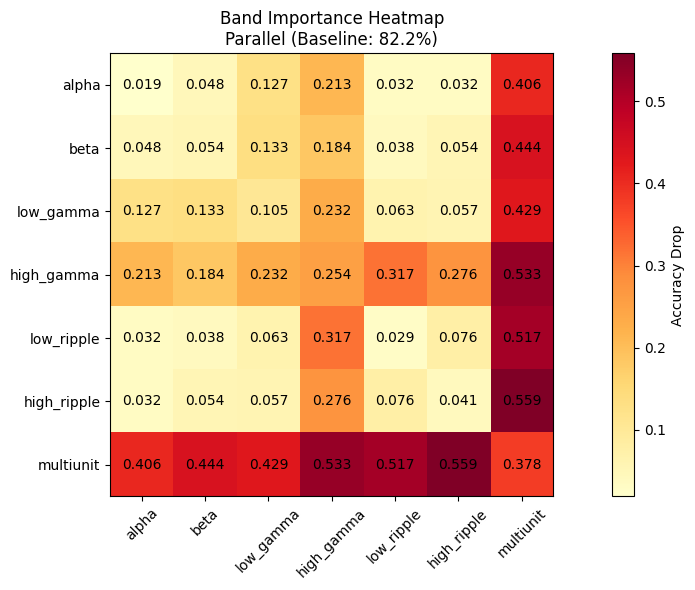

In [57]:
band_imp_parallel_815 = occlusion_importance_per_band(parallel_822, X_test, y_test, bands, model_name="Parallel")


# PCA on Parameters

In [58]:
# PCA on model parameters
def model_PCA(model, layer_name, model_name):
  class_labels = [f"Class {i}" for i in range(9)]

  parallel_model = model.get_layer(layer_name)

  final_layer = parallel_model.layers[-1]  # Last layer
  final_layer_weights = final_layer.get_weights()[0]  # Only weights, not biases

  # Each row is the weight vector for one class
  model_parameters = final_layer_weights.T


  # Perform PCA on these class weight vectors
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(model_parameters)
  print("PCA Result Shape:", pca_result.shape)  # (num_classes, 3)
  print("Explained variance ratio:", pca.explained_variance_ratio_)

  # Visualizing in 3D
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')
  sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                  c=np.arange(pca_result.shape[0]), cmap='viridis', alpha=0.7)

  offset = 0.1
  for i, label in enumerate(class_labels):
      ax.text(
          pca_result[i, 0] + offset, pca_result[i, 1] + offset, pca_result[i, 2] + offset,  # Coordinates
          label,
          fontsize=9,
          ha='center', va='center',
          bbox=dict(facecolor='white', alpha=0.7, lw=0)
      )
  ax.set_xlabel('PCA Component 1')
  ax.set_ylabel('PCA Component 2')
  ax.set_zlabel('PCA Component 3')
  ax.set_title(f'{model_name} 3D PCA of Final Layer Weights')
  plt.colorbar(sc)

  plt.savefig(f"{model_name}_3D_PCA.pdf", format='pdf')

  plt.show()

PCA Result Shape: (9, 3)
Explained variance ratio: [0.21749543 0.18600132 0.1438849 ]


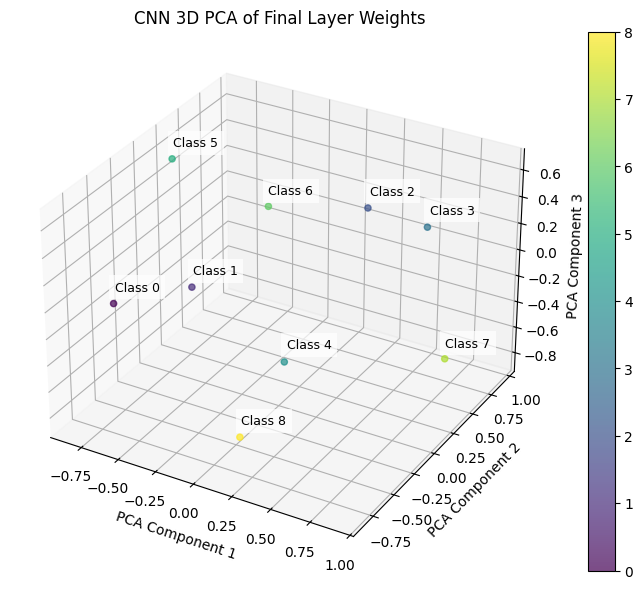

In [59]:
model_PCA(new_cnn, "ConvClassifier", "CNN")

PCA Result Shape: (9, 3)
Explained variance ratio: [0.32088572 0.20496206 0.15125473]


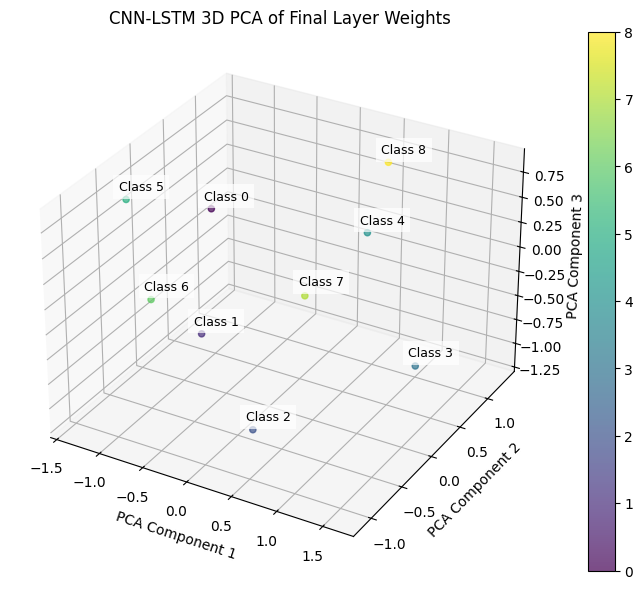

In [63]:
model_PCA(cnn_lstm_832, "sequential_22", "CNN-LSTM")

PCA Result Shape: (9, 3)
Explained variance ratio: [0.217536   0.18945305 0.13751458]


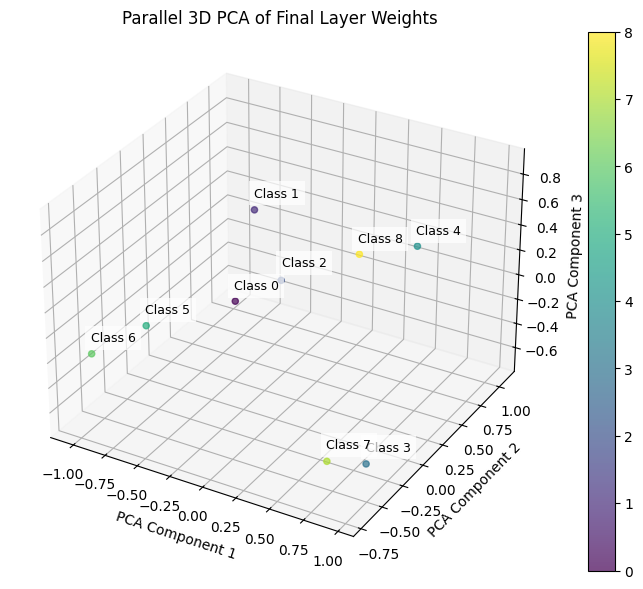

In [64]:
model_PCA(parallel_822, "functional_743", "Parallel")

In [9]:
# confusion matrices

from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns

def plot_confusion(model, X_test, y_test, model_name):

  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  accuracy = accuracy_score(y_test, y_pred_classes)
  train_accuracy = accuracy_score(y_train, np.argmax(model.predict(X_train), axis=1))
  precision = precision_score(y_test, y_pred_classes, average='macro')
  recall = recall_score(y_test, y_pred_classes, average='macro')


  cm = confusion_matrix(y_test, y_pred_classes)

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title(f'{model_name} Confusion Matrix')

  plt.savefig(f"{model_name}_confusion.pdf", format='pdf')

  plt.show()

  print("Train Accuracy: ", train_accuracy)
  print("Test Accuracy: ", accuracy)
  print("Precision: ", precision)
  print("Recall: ", recall)
  print(classification_report(y_test, y_pred_classes))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step


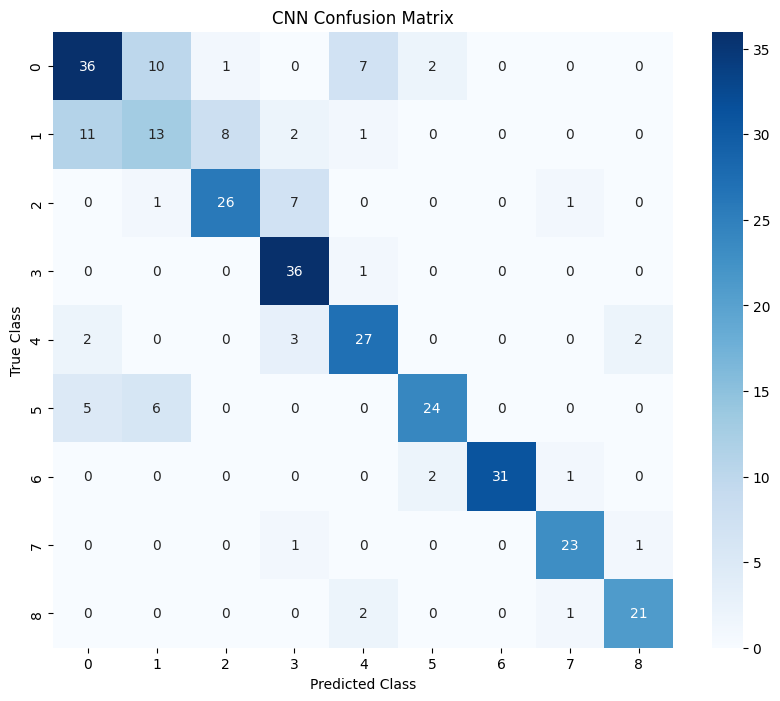

Train Accuracy:  0.8801587301587301
Test Accuracy:  0.7523809523809524
Precision:  0.7672039531062088
Recall:  0.7685236076412547
              precision    recall  f1-score   support

         0.0       0.67      0.64      0.65        56
         1.0       0.43      0.37      0.40        35
         2.0       0.74      0.74      0.74        35
         3.0       0.73      0.97      0.84        37
         4.0       0.71      0.79      0.75        34
         5.0       0.86      0.69      0.76        35
         6.0       1.00      0.91      0.95        34
         7.0       0.88      0.92      0.90        25
         8.0       0.88      0.88      0.88        24

    accuracy                           0.75       315
   macro avg       0.77      0.77      0.76       315
weighted avg       0.75      0.75      0.75       315



In [108]:
plot_confusion(new_cnn, X_test, y_test, "CNN")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


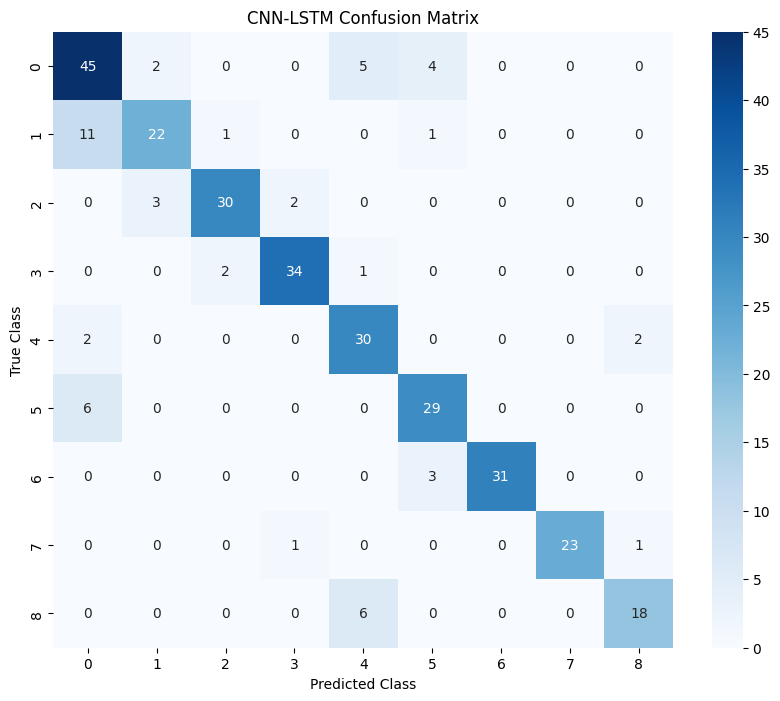

Train Accuracy:  0.8992063492063492
Test Accuracy:  0.8317460317460318
Precision:  0.8556846664485553
Recall:  0.8334326343149873
              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75        56
         1.0       0.81      0.63      0.71        35
         2.0       0.91      0.86      0.88        35
         3.0       0.92      0.92      0.92        37
         4.0       0.71      0.88      0.79        34
         5.0       0.78      0.83      0.81        35
         6.0       1.00      0.91      0.95        34
         7.0       1.00      0.92      0.96        25
         8.0       0.86      0.75      0.80        24

    accuracy                           0.83       315
   macro avg       0.86      0.83      0.84       315
weighted avg       0.84      0.83      0.83       315



In [73]:
plot_confusion(cnn_lstm_832, X_test, y_test, "CNN-LSTM")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


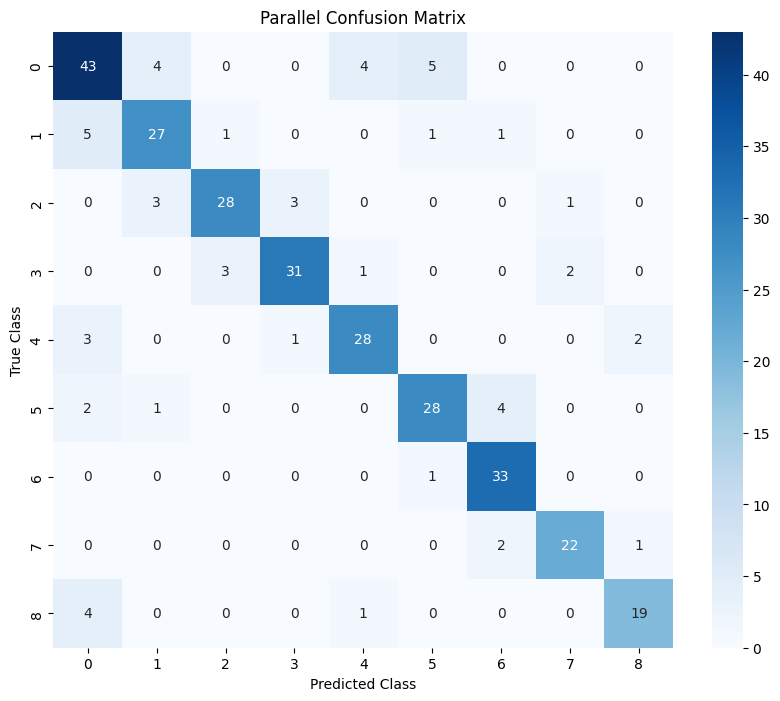

Train Accuracy:  0.9293650793650794
Test Accuracy:  0.8222222222222222
Precision:  0.830966066384023
Recall:  0.8269897628721159
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76        56
         1.0       0.77      0.77      0.77        35
         2.0       0.88      0.80      0.84        35
         3.0       0.89      0.84      0.86        37
         4.0       0.82      0.82      0.82        34
         5.0       0.80      0.80      0.80        35
         6.0       0.82      0.97      0.89        34
         7.0       0.88      0.88      0.88        25
         8.0       0.86      0.79      0.83        24

    accuracy                           0.82       315
   macro avg       0.83      0.83      0.83       315
weighted avg       0.82      0.82      0.82       315



In [109]:
plot_confusion(parallel_822, X_test, y_test, "Parallel")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step


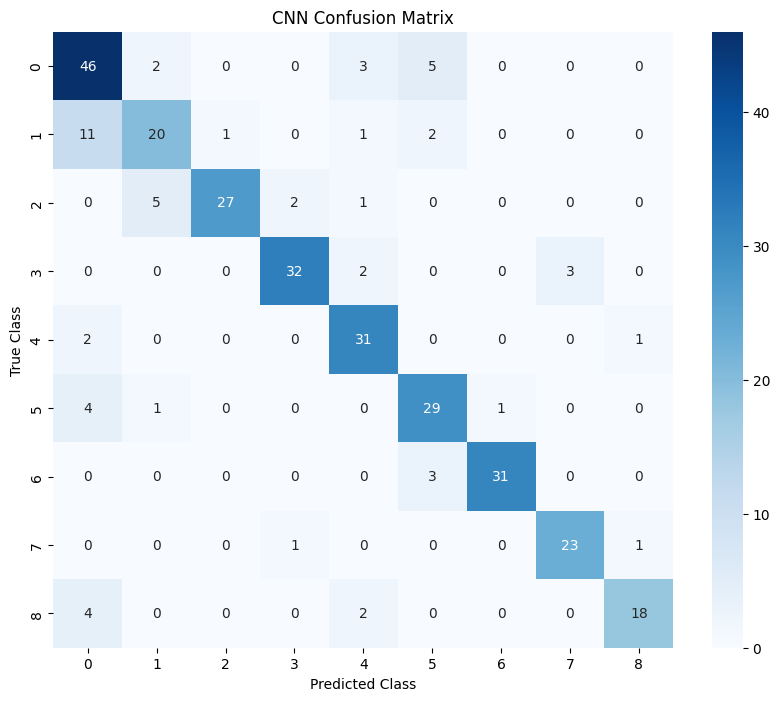

Train Accuracy:  0.9
Test Accuracy:  0.8158730158730159
Precision:  0.839042159471264
Recall:  0.8168057132763015
              precision    recall  f1-score   support

         0.0       0.69      0.82      0.75        56
         1.0       0.71      0.57      0.63        35
         2.0       0.96      0.77      0.86        35
         3.0       0.91      0.86      0.89        37
         4.0       0.78      0.91      0.84        34
         5.0       0.74      0.83      0.78        35
         6.0       0.97      0.91      0.94        34
         7.0       0.88      0.92      0.90        25
         8.0       0.90      0.75      0.82        24

    accuracy                           0.82       315
   macro avg       0.84      0.82      0.82       315
weighted avg       0.83      0.82      0.82       315

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


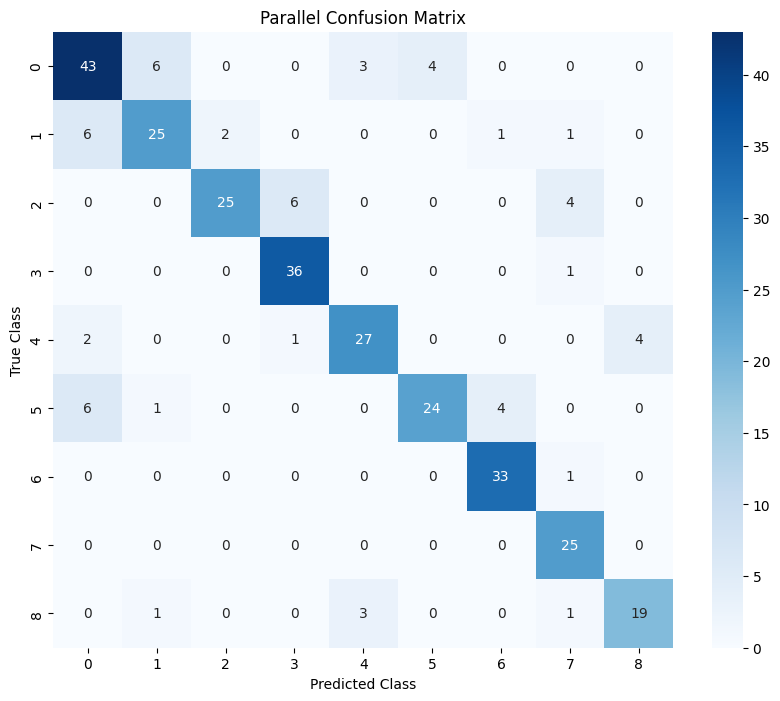

Train Accuracy:  0.9277777777777778
Test Accuracy:  0.8158730158730159
Precision:  0.8225005991992551
Recall:  0.8234987087928265
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76        56
         1.0       0.76      0.71      0.74        35
         2.0       0.93      0.71      0.81        35
         3.0       0.84      0.97      0.90        37
         4.0       0.82      0.79      0.81        34
         5.0       0.86      0.69      0.76        35
         6.0       0.87      0.97      0.92        34
         7.0       0.76      1.00      0.86        25
         8.0       0.83      0.79      0.81        24

    accuracy                           0.82       315
   macro avg       0.82      0.82      0.82       315
weighted avg       0.82      0.82      0.81       315



In [75]:
plot_confusion(cnn_lstm_816, X_test, y_test, "CNN")
plot_confusion(parallel_816, X_test, y_test, "Parallel")

# Visualizations

In [ ]:
pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 14.6 MB/s eta 0:00:00


In [ ]:
# model visualizations

import visualkeras

In [ ]:
# get parts of cnn_model

cnn_model.summary()
encoder = cnn_model.get_layer("Encoder")
encoder.summary()
cnn = cnn_model.get_layer("ConvClassifier")
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 49, 4, 245)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Sequential)            │ (None, 49, 4, 32)      │       204,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ConvClassifier (Sequential)     │ (None, 9)              │       280,009 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,139 (1.85 MB)

 Trainable params: 484,137 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoded_1 (Conv2D)              │ (None, 49, 4, 128)     │       156,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 49, 4, 64)      │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottle (Conv2D)                 │ (None, 49, 4, 32)      │         6,176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,128 (797.38 KB)

 Trainable params: 204,128 (797.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "ConvClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 49, 4, 32)      │        21,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 49, 4, 32)      │        21,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 25, 2, 64)      │        43,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 25, 2, 64)      │        86,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 13, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       106,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,009 (1.07 MB)

 Trainable params: 280,009 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

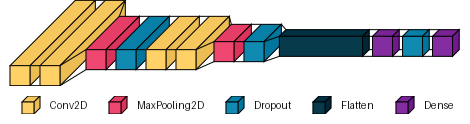

In [ ]:
#visualkeras.layered_view(cnn, legend=True, show_dimension=True)
visualkeras.layered_view(cnn, legend=True, to_file='cnn.pdf')

In [ ]:
cnn_lstm_806.summary()
cnn_lstm = cnn_lstm_806.get_layer("sequential_3")


Model: "Parallel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 49, 4, 245)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Sequential)            │ (None, 49, 4, 32)      │       204,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 9)              │        97,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,515 (1.15 MB)

 Trainable params: 301,513 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


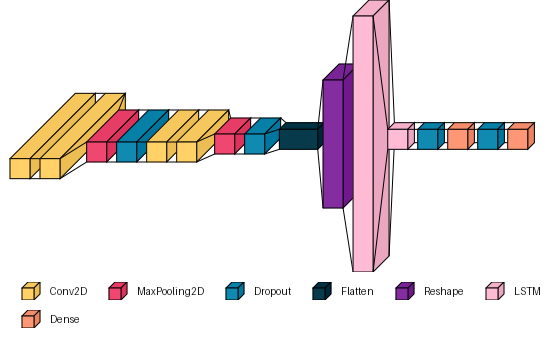

In [ ]:
visualkeras.layered_view(cnn_lstm, legend=True, to_file='cnn_lstm.pdf')